# <center>Lab13: GAN<center/>

111062697 吳律穎

---

1. Implement the Improved WGAN.
2. Train the Improved WGAN on CelebA dataset. Build dataset that read and resize images to 64 x 64 for training.
3. Show a gif of generated samples (at least 8 x 8) to demonstrate the training process and show the best generated sample(s). Please upload to your Google drive and share the link.
4. Draw the loss curve of discriminator and generator during training process into one image.
5. Write a brief report about what you have done.

---

# Import and Parameter setting

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warnings and info
import tensorflow as tf
import tensorflow.keras as keras
import imageio
import moviepy.editor as mpy
import glob
from tqdm import trange


SAMPLE_COL = 8
SAMPLE_ROW = 8
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW

IMG_H = 64
IMG_W = 64
IMG_C = 3
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)

BATCH_SIZE = 512
Z_DIM = 128
BUF = 65536

LR = 1e-4
EPOCH = 256

beta1 = 0
beta2 = 0.9
LAMBDA = 10

IMG_DIR = './imgs/'

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 1 Logical GPUs


# Utility function

In [3]:
def utPuzzle(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out
  
def utMakeGif(imgs, fname, duration):
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t : imgs[int(n * t)], duration = duration)
    clip.write_gif(fname, fps = n)

# Dataset

In [4]:
def map(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMG_C)
    img = tf.image.resize(img, (IMG_H, IMG_W))
    img = tf.cast(img, tf.float32)
    img = img / 255.0
    return img

img_name = glob.glob('./dataset/img_align_celeba_png/*.png')

dataset_train = tf.data.Dataset.from_tensor_slices(img_name)\
                               .map(map, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                               .shuffle(BUF)\
                               .batch(BATCH_SIZE, drop_remainder=True)\
                               .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Model

In [5]:
def GAN(img_shape, z_dim):
    # x-shape
    xh, xw, xc = img_shape
    # z-shape
    zh = xh // 4
    zw = xw // 4
        
    # return Generator and Discriminator
    return keras.Sequential([ # Generator
        keras.layers.Dense(units  =  1024, input_shape = (z_dim,)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(units  =  zh * zw << 8), # zh * zw * 256
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Reshape(target_shape = (zh, zw, 256)),
        keras.layers.Conv2DTranspose(
            filters = 32,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Conv2DTranspose(
            filters = xc,
            kernel_size = 5,
            strides = 2,
            padding = "SAME",
            activation = keras.activations.sigmoid
        ),
    ]), keras.Sequential([ # Discriminator
        keras.layers.Conv2D(
            filters = 32,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME",
            input_shape = img_shape,
        ),
        keras.layers.LeakyReLU(),
        keras.layers.Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME"
        ),
        # keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Flatten(),
        keras.layers.Dense(units  =  1024),
        # keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(units  =  1),
    ])

s = tf.random.normal([SAMPLE_NUM, Z_DIM])

In [6]:
Gen, Dis = GAN(IMG_SHAPE, Z_DIM)
optimizer_g = keras.optimizers.Adam(LR, beta1, beta2)
optimizer_d = keras.optimizers.Adam(LR, beta1, beta2)

@tf.function
def G_train_step(c1):
    z = tf.random.normal([BATCH_SIZE, Z_DIM])

    with tf.GradientTape() as tape:
        c0 = Gen(z, training=True)

        z0 = Dis(c0, training=True)
        z1 = Dis(c1, training=True)

        lg = tf.reduce_mean(-z0)

        epsilon = tf.random.uniform([BATCH_SIZE, 1, 1, 1])
        x_hat = epsilon * c1 + (1 - epsilon) * c0
        gradient_x_hat = tf.gradients(Dis(x_hat, training=True), x_hat)[0]
        l2_norm = (tf.sqrt(tf.reduce_sum(gradient_x_hat ** 2, axis=[1, 2, 3])) - 1.) ** 2
        ld = tf.reduce_mean(z0 - z1 + LAMBDA * l2_norm)

    gradient_g = tape.gradient(lg, Gen.trainable_variables)
    optimizer_g.apply_gradients(zip(gradient_g, Gen.trainable_variables))

    return lg, ld


@tf.function
def D_train_step(c1):
    z = tf.random.normal([BATCH_SIZE, Z_DIM])

    with tf.GradientTape() as tape:
        c0 = Gen(z, training=True)

        z0 = Dis(c0, training=True)
        z1 = Dis(c1, training=True)

        lg = tf.reduce_mean(-z0)

        epsilon = tf.random.uniform([BATCH_SIZE, 1, 1, 1])
        x_hat = epsilon * c1 + (1 - epsilon) * c0
        gradient_x_hat = tf.gradients(Dis(x_hat, training=True), x_hat)[0]
        l2_norm = (tf.sqrt(tf.reduce_sum(gradient_x_hat ** 2, axis=[1, 2, 3])) - 1.) ** 2
        ld = tf.reduce_mean(z0 - z1 + LAMBDA * l2_norm)

    gradient_d = tape.gradient(ld, Dis.trainable_variables)
    optimizer_d.apply_gradients(zip(gradient_d, Dis.trainable_variables))

    return lg, ld

In [7]:
train_step = (
    D_train_step,
    D_train_step,
    D_train_step,
    D_train_step,
    D_train_step,
    G_train_step
)

num_critic = len(train_step)

# Training

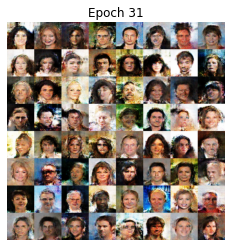

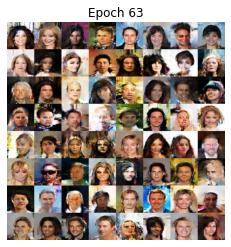

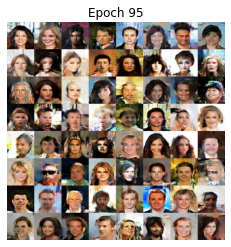

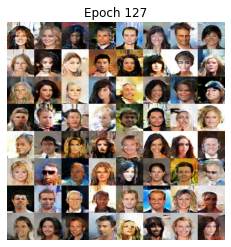

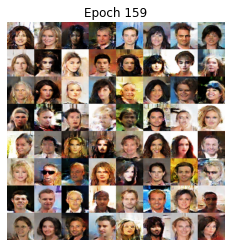

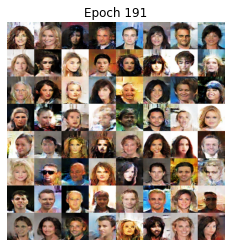

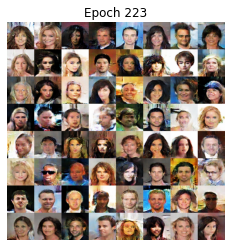

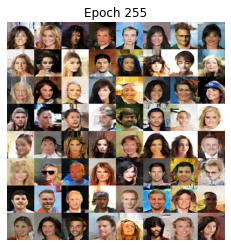

In [8]:
gl_list = [None] * EPOCH
dl_list = [None] * EPOCH
sample_list = [None] * EPOCH  

sample_z = tf.random.normal([SAMPLE_NUM, Z_DIM])

ctr = 0
rsTrain = float(BATCH_SIZE) / float(len(img_name))

for ep in range(EPOCH):
    loss_g_t = 0.0
    loss_d_t = 0.0
    for batch in dataset_train:
        loss_g, loss_d = train_step[ctr](batch)
        ctr += 1
        loss_g_t += loss_g.numpy()
        loss_d_t += loss_d.numpy()
        if ctr == num_critic : ctr = 0
    gl_list[ep] = loss_g_t * rsTrain
    dl_list[ep] = loss_d_t * rsTrain

    out = Gen(sample_z, training=False)

    img = utPuzzle(
        (out * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "imgs/w_improved_%04d.png" % ep
    )
    sample_list[ep] = img

    if (ep + 1) % 32 == 0:
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Epoch {ep:d}')
        plt.show()

# Evaluate 

In [9]:
utMakeGif(np.array(sample_list), "imgs/w_improved_gan.gif", duration=2)

MoviePy - Building file imgs/w_improved_gan.gif with imageio.


![gif](https://drive.google.com/u/2/uc?id=1RkOuwXsoeI26FRUp0jwtuHR26b_bZnod&export=download
)

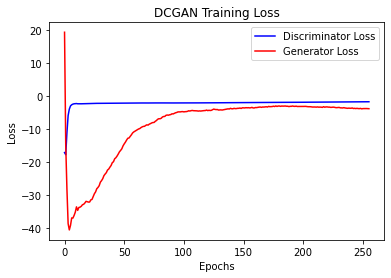

In [10]:
plt.plot(range(EPOCH), dl_list, color = "blue", label = "Discriminator Loss")
plt.plot(range(EPOCH), gl_list, color = "red",  label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("DCGAN Training Loss")
plt.show()

# Report

我的 Loss 是依照 Lab13 notebook 給的 pseudo code 來計算的， hyperparameter 也是依照 pseudo code 上方給的數值來賦值。 而 model architecture 則是直接用 lab13 notebook 中給的架構，並依照 paper 將 Discriminator 的所有 batch Normalization 都移除。 輸出結果大部分的人臉都能正常辨識，但還是有模糊不清的地方。